In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

from Memory import ReplayMemory
from SACV2 import SoftActorCritic
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import sys
sys.path.append("..")
from behavioral_sim.custom_envs import BehavSimEnv
from behavioral_sim.custom_envs import HourlySimEnv

from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.
/Users/lucas.spangher/Documents/Berkeley Files/Research/Deferable Loads/transactive_control/baselines-RAISE/baselines/baselines_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lucas.spangher/Documents/Berkeley Files/Research/Deferable Loads/transactive_control/baselines-RAISE/baselines/baselines_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lucas.spangher/Documents/Berkeley Files/Research/Deferable Loads/transactive_control/baselines-RAISE/baselines/baselines_env/lib/python3.6

In [2]:
"""
My rough code to train and experiment with SACV2, I pretty much just call the train function below


"""

replay_size = 10000


total_numsteps = 60
start_steps = 30
batch_size = 1
action_star = None

## Helper functions

In [3]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def series_to_supervised(data,
                         n_in,
                         target_features,
                         col_names=None,
                         n_out=1,
                         dropnan=True,
                         initial_excluded_timesteps=0,
                         removed_features=[],
                         only_current_timestep_features=[]):
    """Takes time series data and converts it into a supervised learning
    problem framework.

        Parameters:
            - data (pd.Dataframe) -- the time series data to be converted.
            - n_in (int) -- Number of time steps to use as lag for the feature 
                matrix
            - col_names (List[str]) -- list of strings to use as column names,
                that get converted into features for each time lag
            - target_features (List[str]) -- List of features that will be used
                as dependent variables in the target matrix.
            - n_out (int) -- Number of time steps to use as lag for the target
                matrix
            - dropnan (bool) -- Whether to drop nan values
            - initial_excluded_timesteps (int) -- The number of input timesteps to 
                ignore before starting the time lag.
            - removed_features (List[str]) -- List of features that should be removed
                from the dataframe. 
            - only_current_timestep_features (List[str]) -- Features that should
            only be included in the current timestep, not any before (e.g.) to avoid
            unintended dependencies
            
            - [Planned] exclude_current_day (bool) -- Whether to include values 
                from the current day. If this parameter is false, then the time lag 
                will always start with the day preceding the current time 
                step.
                
        Outputs:
            - (X, y): (Feature matrix, target matrix)
    """
    
    if col_names is None:
        col_names = data.columns
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).drop(removed_features, axis=1)
    col_names = [x for x in col_names if x not in removed_features]
    cols, names = list(), list()      
        
    only_prev_time_features = df.drop(only_current_timestep_features, axis=1)
    only_prev_column_names = [x for x in col_names if x in only_prev_time_features.columns]

    # (t-n, ... t-1) --> i.e. steps into the past
    for i in range(n_in + initial_excluded_timesteps, initial_excluded_timesteps, -1):
        cols.append(only_prev_time_features.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in only_prev_column_names]

    # (t, t+1, ... t+n) --> i.e. steps into the future
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in col_names]
        else:
            names += [('%s(t + %d)' % (col, i)) for col in col_names]

    # concat
    agg = pd.concat(cols, axis=1)
#     agg.columns = names

    # dropnan
    if dropnan:
        agg.dropna(inplace=True)
    
    if target_features: 
        Y_vals_cols = ([('%s(t)' % (col)) for col in target_features] + 
            ['%s(t + %d)' % (col, i) for col in target_features for i in range(1, n_out)])

        Y_vals = agg[Y_vals_cols]
        X_vals = agg.drop(Y_vals_cols, axis=1)

        agg.columns = names
              
        return X_vals, Y_vals # X_vals.values, Y_vals.values
    
    else:
        return agg, _



In [4]:
def planning_prediction(action, day_of_week, loaded_model):

    ## load the minMaxScalers
    with open ("scaler_X.pickle", "rb") as input_file:
        scaler_X = pickle.load(input_file) 
    with open ("scaler_y.pickle", "rb") as input_file:
        scaler_y = pickle.load(input_file) 

    ## prepare the data

    d_X = pd.DataFrame(data = { "action"  : action, "dow" : day_of_week } )
    scaled_X = scaler_X.transform(d_X)
    sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 

    preds = loaded_model.predict(sxr)

    inv_preds = scaler_y.inverse_transform(preds)  

    return np.squeeze(inv_preds)

## Train the planning model with more data 

In [5]:
def train_planning_model(
    energy_today, 
    action, 
    day_of_week, 
    loaded_model, 
    filename_to_save = "GPyOpt_planning_model"
):
    
    ## load the minMaxScalers
    with open ("scaler_X.pickle", "rb") as input_file:
        scaler_X = pickle.load(input_file) 
    with open ("scaler_y.pickle", "rb") as input_file:
        scaler_y = pickle.load(input_file) 

    ## prepare the data

    d_X = pd.DataFrame(data = { "action" : action, "dow" : day_of_week } )
    scaled_X = scaler_X.transform(d_X)
    sxr = scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1])) 
    
    d_y = pd.DataFrame(data = {"energy" : energy_today})
    scaled_y = scaler_y.transform(d_y)
    
    loaded_model.fit(
            sxr,    ## these all need to be changed if the GPyOpt evaluates differently
            scaled_y,
            epochs=100,
            batch_size=10,
            validation_split=0.0,
            verbose=0,
        )
    
    model_json = loaded_model.to_json()
    with open(filename_to_save + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    loaded_model.save_weights(filename_to_save + ".h5")
    print("Saved model to disk")
    
    return

## load model

In [6]:
def load_model_from_disk(file_name = "GPyOpt_planning_model"):
    json_file = open(file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(file_name + ".h5")
    print("Loaded model from disk")

    loaded_model.compile(loss="mse", optimizer="adam")
    return loaded_model

## Train function


In [11]:
def train(response_type_str, 
    extra_train, 
    planning_iterations,
    one_day = False, 
    energy=True, 
    day_of_week=True, 
    planning_model = False,
    train_planning_model_with_new_data = False,
    ):
    """
    Args: 
        Response_type_str = 'theshold_exp' or 'sin' or 'mixed' or 'linear'
        Extra_Train = Number of iterations to "overtrain"
        planning_iterations = number of times to query the planning model
        One_day: Whether to train from a single day's price signal 
        Energy: Whether or not to include previous day energy in the state
        Day_of_Week: Whether or not to include day_of_week multiplier
        planning_model: whether or not to use the planning model
        train_planning_model_with_new_data= whether to train the planning model
    
    Summary:
        This code 'simulates' a run of SACV2 training and acting over 30 days (takes a step each day)

    """
    if(response_type_str == 'threshold_exp'):
        #env = HourlySimEnv(response='t', one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='t', one_day = one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'sin'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='s', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'mixed'):
        #env = HourlySimEnv(response='s',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='m', one_day=one_day, energy_in_state=energy, yesterday_in_state=False,
                            day_of_week = day_of_week)
    elif(response_type_str == 'linear'):
        #env = HourlySimEnv(response='l',one_day=True, energy_in_state=False)
        env2 = BehavSimEnv(response='l', one_day=one_day, energy_in_state=energy,yesterday_in_state=False,
                            day_of_week = day_of_week)
    
    else:
        raise NotImplementedError

    #rewards in environment that agents see
    rewards = []

    #optional rewards list for environment that agent doesn't see (used in one-day training -> generalization case)
    rewards2 = []

    min_combined_losses = []
    min_policy_losses = []
    min_alpha_losses = []
    num_iters_list = []
    overall_best_action = None

    memory = ReplayMemory(replay_size)

    #Sometimes use 2 environment, this is used to default to 1 env. 
    #Change if you want to use 2 environments
    env = env2

    action_star = []
    state = None


    agent = SoftActorCritic(env.observation_space, env.action_space, memory)

    reward_planning = []
    
    # Actions 2 save and energy_usage for data_generation
    # actions_2_save = []
    # energy_usage = []

    # Flag corresp to whether first state has been initialized
    start_flag = False

    while (env.day <= 60):
        step = env.day
        day_of_week = env.day % 7 
        print("Day: " + str(step))
        if (not start_flag):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = np.copy(next_state)
            start_flag = True
            continue

        if env.day <= 30:
            action = env.action_space.sample()  # Sample random action
            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))

            state = np.copy(next_state)
            continue
            
        else:
            if(memory.get_len() > batch_size):
                critic_1_losses = [None]
                critic_2_losses = [None]
                policy_losses = [None]
                alpha_losses = [None]
                actions = []
                for extra_step in range(extra_train):
                    print("--"*10)
                    print(" Extra Train " + str(extra_step))
                    q1_prev_loss = critic_1_losses[-1]
                    q2_prev_loss = critic_2_losses[-1]
                    policy_loss = policy_losses[-1]
                    alpha_loss = alpha_losses[-1]
                    return_update = agent.update_params(batch_size, memory_type = "replay")
                    print(return_update)
                    print("--"*10)
                    critic_1_loss = return_update[0]
                    critic_2_loss = return_update[1]
                    policy_loss = return_update[2]
                    alpha_loss = return_update[3]

                    critic_1_losses.append(critic_1_loss)
                    critic_2_losses.append(critic_2_loss)
                    policy_losses.append(policy_loss)
                    alpha_losses.append(alpha_loss)

                energy_yesterday = np.copy(next_state[:10])

                if planning_model:
                    
                    ## load model from disk now   
                    if train_planning_model_with_new_data:
                        if (env.day==31):
                            loaded_model = load_model_from_disk("GPyOpt_planning_model")
                        else:
                            loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    else: 
                        loaded_model = load_model_from_disk("GPyOpt_planning_model")
            
                    for planning_step in range(planning_iterations):
                        print("--"*10)
                        print(" planning step " + str(planning_step))
                        q1_prev_loss = critic_1_losses[-1]
                        q2_prev_loss = critic_2_losses[-1]
                        policy_loss = policy_losses[-1]
                        alpha_loss = alpha_losses[-1]

                        grid_prices_today = env.prices[env.day] # assuming that the env.day here correctly is set to the correct day
                        grid_prices_tmr = env.prices[(env.day + 1) % 365]
                        # state is defined as [previous day energy, current day prices] 
                        # I don't currently want this to change, as it should be the same to allow agent to explore

                        state = np.concatenate((energy_yesterday, grid_prices_today))
                        action = agent.get_action(state)
                        
                        print("action this time: " + str(action))
                     
                        planned_energy_consumption = planning_prediction(action, day_of_week, loaded_model)
                        
                        # will define next state as [energy, grid prices tomorrow]

                        next_state = np.concatenate((planned_energy_consumption, grid_prices_tmr))
                        reward = env.get_reward_planning_model(grid_prices_today, planned_energy_consumption) 
                        done = True

                        agent.planning_replay_memory.push((state, action, reward, next_state, done))
                        
                        return_update = agent.update_params(batch_size, memory_type = "planning")
                        
                        print(return_update)
                        print("--"*10)
                        critic_1_loss = return_update[0]
                        critic_2_loss = return_update[1]
                        policy_loss = return_update[2]
                        alpha_loss = return_update[3]

                        critic_1_losses.append(critic_1_loss)
                        critic_2_losses.append(critic_2_loss)
                        policy_losses.append(policy_loss)
                        alpha_losses.append(alpha_loss)
                        reward_planning.append(reward)
                        # num_iters_list.append(num_iters)
                        # actions.append(agent.get_action(state))
            
            #Finds the action corresp to the lowest combined q-loss
            # combined_q_loss = np.array(critic_1_losses[1:]) + np.array(critic_2_losses[1:])
            # min_loss = np.amin(combined_q_loss)
            # min_combined_losses.append(min_loss)
            # index_of_min = np.where(combined_q_loss == min_loss)[0][0]
            
            action = agent.get_action(state)

            # min_policy_losses.append(np.amin(np.array(policy_losses)))
            # min_alpha_losses.append(np.amin(np.array(alpha_losses)))

            next_state, reward, done, info = env.step(action)

            memory.push((state, action, reward, next_state, done))
            
            # train the planning model 
            energy_today = np.copy(next_state[:10])
                        
            # if training the planning model is the flag that we'll change, then 
            # change over to "planning_model_training" and train it 
            
            if train_planning_model_with_new_data:
                if env.day == 31:
                    loaded_model = load_model_from_disk("GPyOpt_planning_model_training")
                    
                train_planning_model(    
                    energy_today = energy_today, 
                    action = action, 
                    day_of_week = day_of_week, 
                    loaded_model = loaded_model
                )
            
            state = np.copy(next_state)

            if(done):
                rewards.append(reward)
            print("--------" * 10)
    
    return rewards, critic_1_losses, critic_2_losses, policy_losses, alpha_losses, reward_planning



In [8]:
def train_curve_finder(max_iter, response_type_str):
    def train_store_rewards(response_type_str):
        sampled_days = [19,16,29,18,14,23,9,21,10,30]
        #Key = Day | Val = list for SAC Reward
        rewards_dict = {i: [] for i in range(1,max_iter,10)}
        for iteration in range(1,max_iter,10):
            #Add error bounds, just for loop then return avg, pointwise-max/min
            for i in range(5):
                curr_rewards_sac = train(response_type_str,iteration, energy=True, day_of_week=True)
                rewards_dict[iteration].append(curr_rewards_sac)   
        return rewards_dict
        
    sac_rewards_dict = train_store_rewards(response_type_str)
    for et in sac_rewards_dict.keys():
        sac_rewards_iter_et = sac_rewards_dict[et]
        print(sac_rewards_iter_et)
        print("----\n"*2)
        np.save("SACV2_" + response_type_str + "_" + str(et) + "_rewards_no_seed",sac_rewards_iter_et)

In [7]:
rewards_both, critic_1_losses_both, critic_2_losses_both, policy_losses_both, alpha_losses_both = train(response_type_str = "mixed", 
         extra_train = 40, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
--------------------
 Extra Train 40
(34683364.0, 34534568.0, 215.89706420898438, -0.0)
--------------------
--------------------
 Extra Train 40
(16438818.0, 16350577.0, 202.16371154785156, -0.062017772346735)
--------------------
--------------------
 Extra Train 40
(19999352.0, 19908194.0, 187.90110778808594, -0.11395933479070663)
--------------------
--------------------
 Extra Train 40
(10616145.0, 10595111.0, 179.09400939941406, -0.1628684103488922)
--------------------
--------------------
 Extra Train 40
(30836828.0, 30749992.0, 191.8766632080078, -0.23605185747146606)
--------------------
--------------------
 Extra Train 40
(5906036.5, 5915489.5, 181.79933166503906, -0.27248498797416687)
-----------------

In [11]:
rewards_extra_train, critic_1_losses_extra_train, critic_2_losses_extra_train, policy_losses_extra_train, alpha_losses_extra_train = train(response_type_str = "mixed", 
         extra_train = 40, 
         energy = True,
         day_of_week = True,
         planning_model = False,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
--------------------
 Extra Train 0
(30600502.0, 27421494.0, 437.92230224609375, -0.0)
--------------------
--------------------
 Extra Train 1
(29564568.0, 26564270.0, 427.10296630859375, -0.07575112581253052)
--------------------
--------------------
 Extra Train 2
(4517009.5, 3334255.0, 446.3385009765625, -0.1509958803653717)
--------------------
--------------------
 Extra Train 3
(18337288.0, 15771878.0, 464.69073486328125, -0.22479236125946045)
--------------------
--------------------
 Extra Train 4
(17409336.0, 14502686.0, 499.564453125, -0.3026440739631653)
--------------------
--------------------
 Extra Train 5
(30472320.0, 27251550.0, 454.74993896484375, -0.3770979940891266)
--------------------
-------

In [16]:
rewards_plan, critic_1_losses_plan, critic_2_losses_plan, policy_losses_plan, alpha_losses_plan = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 40
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(14343116.0, 15861702.0, 428.32598876953125, -0.0)
--------------------
--------------------
 planning step 1
(14280516.0, 15829024.0, 438.1231994628906, -0.07580889761447906)
--------------------
--------------------
 planning step 2
(14138724.0, 15712969.0, 445.02490234375, -0.15170998871326447)
--------------------
--------------------
 planning step 3
(14137321.0, 15745489.0, 451.56689453125, -0.2273496687412262)
--------------------
--------------------
 planning step 4
(14020156.0, 15656129.0, 456.666259765625, -0.30108150839805603)
--------------------
--------------------
 planning step 5
(14096661.0, 15771616.0, 456.9759521484375, -0.366260707378

In [ ]:
rewards_wo, critic_1_losses_wo, critic_2_losses_wo, policy_losses_wo, alpha_losses_wo = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = False,
         planning_iterations = 10
         )

## Plotting

Text(0,0.5,'Rewards')

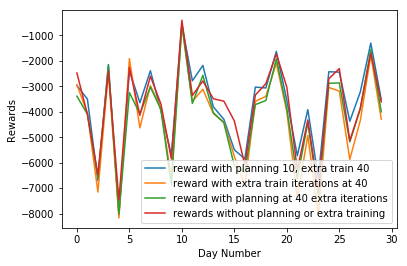

In [22]:
plt.figure()
plt.plot(rewards_both, label = 'reward with planning 10, extra train 40')
plt.plot(rewards_extra_train, label = "reward with extra train iterations at 40")
plt.plot(rewards_plan, label = "reward with planning at 40 extra iterations")
plt.plot(rewards_wo, label = "rewards without planning or extra training")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")



In [27]:
print("total reward without:" + str(sum(rewards_wo)))
print("total reward with extra train:" + str(sum(rewards_extra_train)))
print("total reward with planning:" + str(sum(rewards_plan)))
print("total reward with both:" + str(sum(rewards_both)))

total reward without:-113642.31469338658
total reward with extra train:-129226.22927744042
total reward with planning:-125111.46310461816
total reward with both:-111316.40735969838


Text(0,0.5,'Rewards')

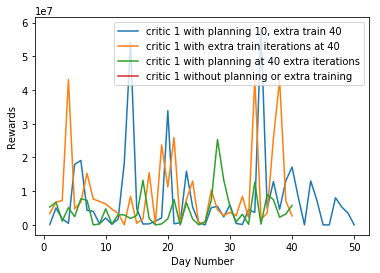

In [29]:
plt.figure()
plt.plot(critic_1_losses_both, label = 'critic 1 with planning 10, extra train 40')
plt.plot(critic_1_losses_extra_train, label = "critic 1 with extra train iterations at 40")
plt.plot(critic_1_losses_plan, label = "critic 1 with planning at 40 extra iterations")
plt.plot(critic_1_losses_wo, label = "critic 1 without planning or extra training")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")

## Testing different numbers of planning iterations

In [10]:
rewards_plan_10, critic_1_losses_plan_10, critic_2_losses_plan_10, policy_losses_plan_10, alpha_losses_plan_10, reward_planning_10 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(17329232.0, 16397596.0, 227.83123779296875, -0.0)
--------------------
--------------------
 planning step 1
(17350946.0, 16422529.0, 247.1032257080078, -0.056017253547906876)
--------------------
--------------------
 planning step 2
(17441856.0, 16514578.0, 247.1073760986328, -0.11077799648046494)
--------------------
--------------------
 planning step 3
(17335802.0, 16414973.0, 246.16201782226562, -0.16309699416160583)
--------------------
--------------------
 planning step 4
(17281628.0, 16367536.0, 249.35910034179688, -0.21930038928985596)
--------------------
--------------------
 planning step 5
(17277632.0, 16368873.0, 226.82650756835938, -0.23

In [31]:
rewards_plan_30, critic_1_losses_plan_30, critic_2_losses_plan_30, policy_losses_plan_30, alpha_losses_plan_30 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 30
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(13022578.0, 12996620.0, 240.21534729003906, -0.0)
--------------------
--------------------
 planning step 1
(12980652.0, 12977218.0, 234.10873413085938, -0.06721147149801254)
--------------------
--------------------
 planning step 2
(12952337.0, 12971425.0, 232.56224060058594, -0.1318109929561615)
--------------------
--------------------
 planning step 3
(12927503.0, 12969128.0, 231.7638397216797, -0.19403041899204254)
--------------------
--------------------
 planning step 4
(12883368.0, 12947505.0, 230.49459838867188, -0.2532074749469757)
--------------------
--------------------
 planning step 5
(12894736.0, 12981558.0, 232.43643188476562, -0.3143

In [56]:
rewards_plan_50, critic_1_losses_plan_50, critic_2_losses_plan_50, policy_losses_plan_50, alpha_losses_plan_50, reward_planning_50 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 50
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(17589050.0, 18275988.0, 278.5548400878906, -0.0)
--------------------
--------------------
 planning step 1
(17494258.0, 18206802.0, 272.2568054199219, -0.0587289035320282)
--------------------
--------------------
 planning step 2
(17490954.0, 18231140.0, 273.4970703125, -0.1151764765381813)
--------------------
--------------------
 planning step 3
(17349638.0, 18114624.0, 277.0526123046875, -0.1714525669813156)
--------------------
--------------------
 planning step 4
(17335882.0, 18128730.0, 283.658935546875, -0.23052829504013062)
--------------------
--------------------
 planning step 5
(17321166.0, 18140686.0, 283.02410888671875, -0.2800387740135

In [33]:
rewards_plan_100, critic_1_losses_plan_100, critic_2_losses_plan_100, policy_losses_plan_100, alpha_losses_plan_100 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 100
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(16944270.0, 17393750.0, 69.08904266357422, -0.0)
--------------------
--------------------
 planning step 1
(16889480.0, 17322192.0, 69.31834411621094, -0.03950157016515732)
--------------------
--------------------
 planning step 2
(16846266.0, 17264902.0, 81.75672912597656, -0.0842730849981308)
--------------------
--------------------
 planning step 3
(16952910.0, 17354758.0, 55.050559997558594, -0.10162992030382156)
--------------------
--------------------
 planning step 4
(16889274.0, 17274750.0, 83.21516418457031, -0.16135285794734955)
--------------------
--------------------
 planning step 5
(16876744.0, 17246516.0, 80.3991470336914, -0.19197732

Text(0,0.5,'Rewards')

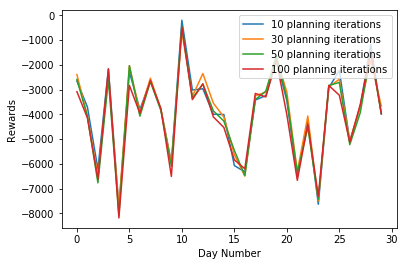

In [57]:
plt.figure()
plt.plot(rewards_plan_10, label = '10 planning iterations')
plt.plot(rewards_plan_30, label = "30 planning iterations")
plt.plot(rewards_plan_50, label = "50 planning iterations")
plt.plot(rewards_plan_100, label = "100 planning iterations")
plt.legend()
plt.xlabel("Day Number")
plt.ylabel("Rewards")


In [59]:
print(sum(rewards_plan_10))
print(sum(rewards_plan_30))    ## here, in 30 the planning model was allowed to train, and it 
print(sum(rewards_plan_50)) ## has the lowest overall rewards 
print(sum(rewards_plan_100))

-117021.11855134189
-116192.64809836443
-119356.09972273273
-122087.17951700819


In [154]:
plt.figure()
plt.plot(reward_planning_50[1200:], label = "reward when planning model trains")
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 1 Axes>


## Planning model trains

In [95]:
rewards_plan_10_train,_,_,_,_, planning_rewards_10 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 10,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_30_train, _,_,_,_, planning_rewards_30 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 30,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_50_train,_,_,_,_, planning_rewards_50 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 50,
         train_planning_model_with_new_data = True,   
         )

rewards_plan_100_train,_,_,_,_, planning_rewards_100 = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         planning_model = True,
         planning_iterations = 100,
         train_planning_model_with_new_data = True,   
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(18458200.0, 18735080.0, 113.42548370361328, -0.0)
--------------------
--------------------
 planning step 1
(18365322.0, 18653892.0, 130.5730743408203, -0.04927534982562065)
--------------------
--------------------
 planning step 2
(18426324.0, 18736970.0, 123.01703643798828, -0.09096065908670425)
--------------------
--------------------
 planning step 3
(18337858.0, 18660148.0, 135.24420166015625, -0.14268597960472107)
--------------------
--------------------
 planning step 4
(18430616.0, 18766876.0, 133.48556518554688, -0.18367041647434235)
--------------------
--------------------
 planning step 5
(18211236.0, 18558998.0, 133.1405487060547, -0.219

In [16]:
pd.DataFrame(rewards_plan_10_train).to_csv("rewards_10plan_train.csv")
pd.DataFrame(rewards_plan_30_train).to_csv("rewards_30plan_train.csv")
pd.DataFrame(rewards_plan_50_train).to_csv("rewards_50plan_train.csv")
pd.DataFrame(rewards_plan_100_train).to_csv("rewards_100plan_train.csv")

NameError: name 'rewards_plan_100_train' is not defined

In [163]:
plt.figure()
plt.plot(planning_rewards_10)
plt.plot(planning_rewards_30, label = "rewards 30 iterations")
plt.plot(planning_rewards_50, label = "rewards 50 iterations")
plt.plot(planning_rewards_100, label = "rewards 100 iterations")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 1 Axes>


In [168]:
pd.DataFrame(planning_rewards_10).to_csv("planning_rewards_10.csv")
pd.DataFrame(planning_rewards_30).to_csv("planning_rewards_30.csv")
pd.DataFrame(planning_rewards_50).to_csv("planning_rewards_50.csv")
pd.DataFrame(planning_rewards_100).to_csv("planning_rewards_100.csv")

pd.DataFrame(planning_rewards_oneday_10).to_csv("planning_rewards_oneday_10.csv")
pd.DataFrame(planning_rewards_oneday_30).to_csv("planning_rewards_oneday_30.csv")
pd.DataFrame(planning_rewards_oneday_50).to_csv("planning_rewards_oneday_50.csv")
pd.DataFrame(planning_rewards_oneday_100).to_csv("planning_rewards_oneday_100.csv")

## Trying out planning iterations in a one day scenario

In [94]:
rewards_plan_oneday_10, _, _, _, _, planning_rewards_oneday_10  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 10,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_30, _, _, _, _, planning_rewards_oneday_30  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 30,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_50, _, _, _, _, planning_rewards_oneday_50  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 50,
         train_planning_model_with_new_data = False,   
         )

rewards_plan_oneday_100, _, _, _, _, planning_rewards_oneday_100  = train(response_type_str = "mixed", 
         extra_train = 0, 
         energy = True,
         day_of_week = True,
         one_day = True,
         planning_model = True,
         planning_iterations = 100,
         train_planning_model_with_new_data = False,   
         )

BehavSimEnv Initialized
20
10
Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7
Day: 8
Day: 9
Day: 10
Day: 11
Day: 12
Day: 13
Day: 14
Day: 15
Day: 16
Day: 17
Day: 18
Day: 19
Day: 20
Day: 21
Day: 22
Day: 23
Day: 24
Day: 25
Day: 26
Day: 27
Day: 28
Day: 29
Day: 30
Day: 31
Loaded model from disk
--------------------
 planning step 0
(59354.41796875, 25791.009765625, 119.36029815673828, -0.0)
--------------------
--------------------
 planning step 1
(56127.109375, 24876.263671875, 109.0294189453125, -0.03974607214331627)
--------------------
--------------------
 planning step 2
(51487.26171875, 22966.732421875, 117.05854797363281, -0.08327951282262802)
--------------------
--------------------
 planning step 3
(51117.59765625, 23883.2265625, 114.83958435058594, -0.12176123261451721)
--------------------
--------------------
 planning step 4
(49236.3984375, 24793.673828125, 123.20551300048828, -0.1706317812204361)
--------------------
--------------------
 planning step 5
(47871.5234